<a href="https://colab.research.google.com/github/dgalassi99/quant-trading-self-study/blob/main/01_foundations/W3_MA_strategy_refined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Refining the MA Trading Strategy

## Importing libraries and data

In [18]:
#importing main libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

In [138]:
tickers = ['JNJ','NKE','AAPL','ETN','INTC','C']
#let's take a 10 years horizon
start_date = '2015-01-01'
end_date = '2025-01-01'
#create a dictionary where key = ticker name and value is ticker data for each tick in tickers
data = {}
for tik in tickers:
  data[tik] = yf.download(tik, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Analyzing a Single Ticker

### First Definitions

In [152]:
tik = 'INTC'
#we will just keep close and volume as we assume the strategy is not on the short time frame
#hence we will not 'trade intraday
df = data[tik][['Close', 'Volume']]
#dropping the outer level of the columns to avoid having a multiindex dataset
df = df.droplevel(level=1, axis=1)

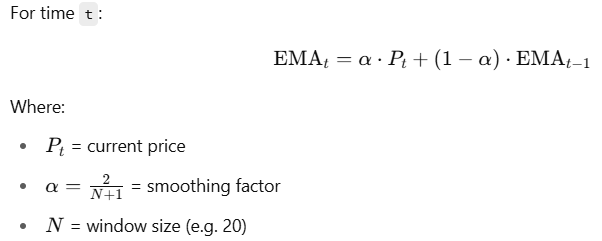

In [153]:
#to differentiuate from last wek today we will use exponential moving averages (EMAs)
shortEMA = 100
longEMA = 200
df['shortEMA'] = df['Close'].ewm(span=shortEMA, adjust=False).mean()
df['longEMA'] = df['Close'].ewm(span=longEMA, adjust=False).mean()

In [154]:
#define the position variable
df['position'] = np.where(df['shortEMA'] > df['longEMA'], 1, 0)

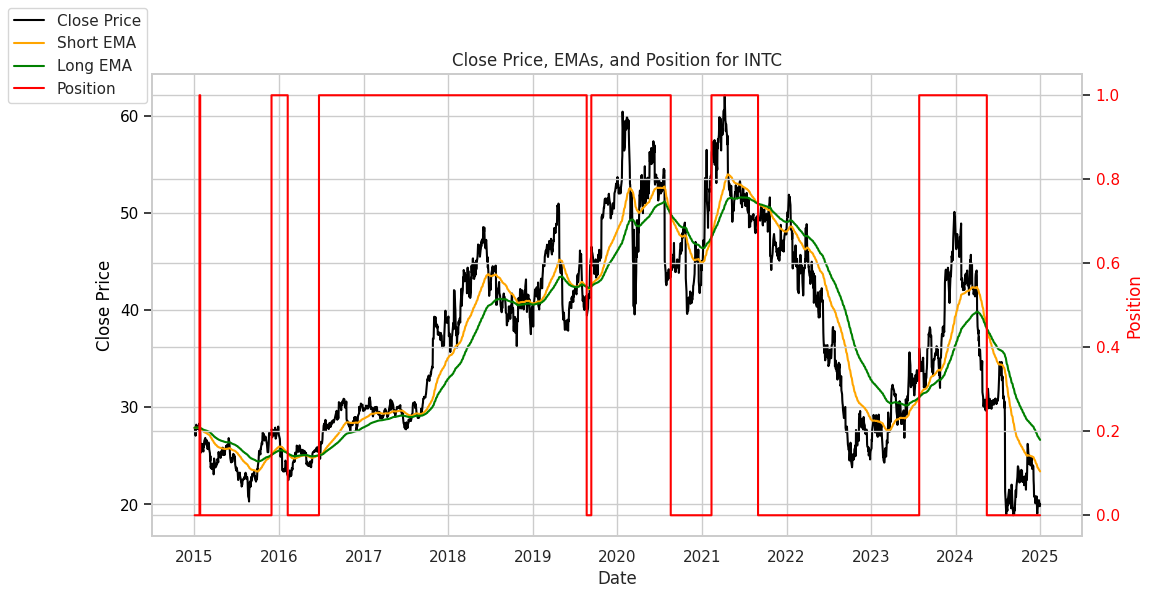

In [155]:
#visualize the price evolution and the signal
fig, ax1 = plt.subplots(figsize=(12, 6))

#Close price
ax1.plot(df.index, df['Close'], label='Close Price', color='black')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='black')
ax1.tick_params('y', labelcolor='black')
#Positioning
ax2 = ax1.twinx()
ax2.step(df.index, df['position'], label='Position', color='red', where='post',linestyle='-')  # Use 'step' for position
ax2.set_ylabel('Position', color='red')
ax2.tick_params('y', labelcolor='red')
#EMAs
ax1.plot(df.index, df['shortEMA'], label='Short EMA', color='orange')
ax1.plot(df.index, df['longEMA'], label='Long EMA', color='green')

plt.title('Close Price, EMAs, and Position for '+ str(tik))
fig.legend(loc='upper left')
plt.grid(True)
plt.show()

### Buy & Hold vs Crossing EMAs (Long Only)

In [156]:
#calucalte daily return with buy n hold and with crossing strategy

#buy&hold
df['daily_return_bnh'] = df['Close'].pct_change()
#strategy
df['daily_return_strategy'] = df['daily_return_bnh'] * df['position'].shift(1)
#cumulative returns
df['cumulative_bnh'] = (1 + df['daily_return_bnh']).cumprod()
df['cumulative_strategy'] = (1 + df['daily_return_strategy']).cumprod()

Why shifting one one row?
Position represent the status of my portfolio at the end of the day but the daily return of the asset happens in the current day. So we need to shift since we clsoe poition at the end of the previous day and not during the current one

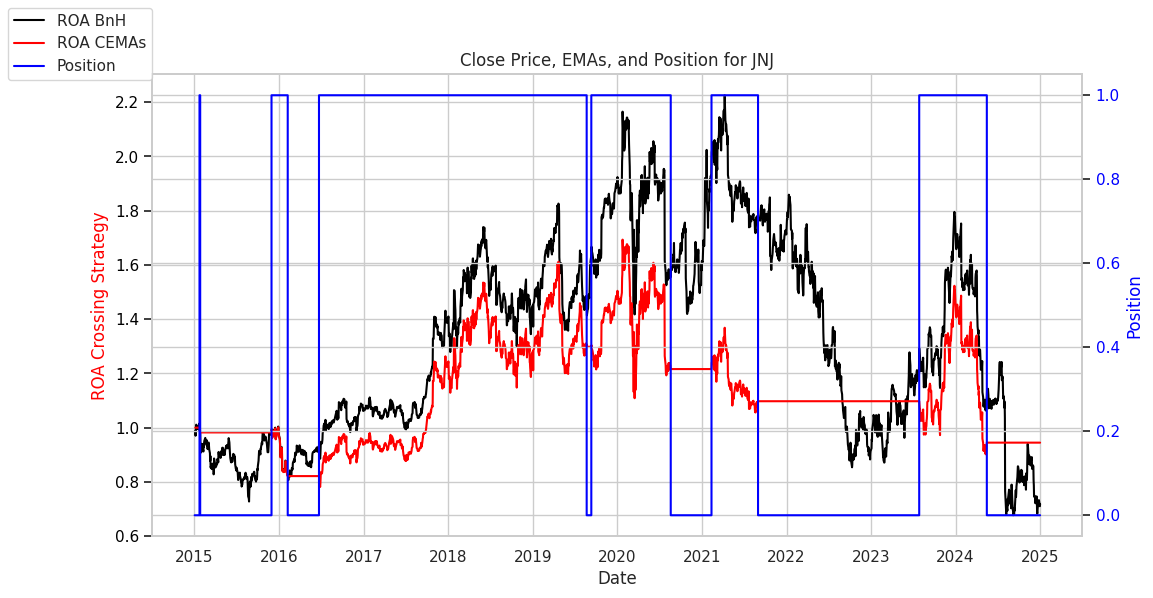

In [157]:
#visualize the price evolution and the signal
fig, ax1 = plt.subplots(figsize=(12, 6))

#ROA buy n hold
ax1.plot(df.index, df['cumulative_bnh'], label='ROA BnH', color='black')
ax1.set_xlabel('Date')
ax1.set_ylabel('ROA Buy & Hold', color='black')
ax1.tick_params('y', labelcolor='black')
#ROA strategy
ax1.plot(df.index, df['cumulative_strategy'], label='ROA CEMAs', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('ROA Crossing Strategy', color='red')
ax1.tick_params('y', labelcolor='black')
#Position
ax2 = ax1.twinx()
ax2.step(df.index, df['position'], label='Position', color='blue', where='post',linestyle='-')  # Use 'step' for position
ax2.set_ylabel('Position', color='blue')
ax2.tick_params('y', labelcolor='blue')

plt.title('Close Price, EMAs, and Position for JNJ')
fig.legend(loc='upper left')
plt.grid(True)
plt.show()

### Adding Slippage and Transaction Costs

Now we create the strategy when dealing with slippage and slippage + transaction cost. We neglect the transaction csot and slippage on buy and hold to avoid introducing other complexities since only one transaction will take place in this case.

We will use buy n hold and no cost strategy as references of the case treated before

In [158]:
slippage_pct = 0.002 #0.2% cost of slippage
transaction_cost_pct = 0.005 #0.5% cost of transaction

#flag where a trade
df['slippage_flag'] = np.where(df['position'] != df['position'].shift(1), 1, 0)
#the close price of the next period is going to be higher due to slippage but this change is only applied whhen we enter a long
#that is why slippage is defined as position shifted to the next day
df['close_with_slippage'] = df['Close'] * (1 + slippage_pct * df['slippage_flag'])
df['daily_return_strategy_with_slippage'] = df['close_with_slippage'].pct_change() * df['position'].shift(1)
df['cumulative_strategy_with_slippage'] = (1 + df['daily_return_strategy_with_slippage']).cumprod()

#add transaction cost (only when there is a position change)
df['transaction_cost'] = np.where(df['slippage_flag'] == 1, transaction_cost_pct, 0)
df['daily_return_strategy_with_costs'] = df['daily_return_strategy_with_slippage'] - df['transaction_cost']
df['cumulative_strategy_with_slippage_and_costs'] = (1 + df['daily_return_strategy_with_costs']).cumprod()


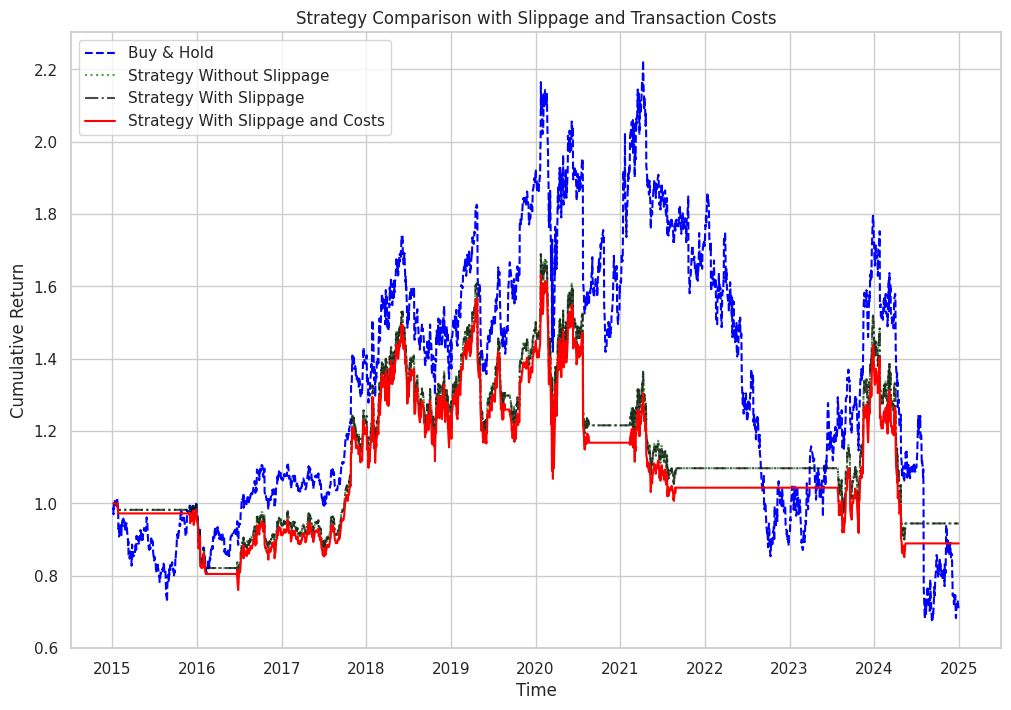

In [159]:
plt.figure(figsize=(12, 8))

#all strategies
plt.plot(df['cumulative_bnh'], label='Buy & Hold', linestyle='--', color='blue')
plt.plot(df['cumulative_strategy'], label='Strategy Without Slippage', color='green',linestyle=':',alpha=0.7)
plt.plot(df['cumulative_strategy_with_slippage'], label='Strategy With Slippage', color='black',linestyle='-.',alpha=0.7)
plt.plot(df['cumulative_strategy_with_slippage_and_costs'], label='Strategy With Slippage and Costs', color='red')

plt.title("Strategy Comparison with Slippage and Transaction Costs")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc='upper left')
plt.show()


## Focus on Real Startegy (slippage + transaction cost)

### Distributions of Returs when we invest in different moments?

Differetnly from week 2 here we also consider the following point. When positio is 0, which means i am not long in the market I am losing an opportunity cost. Which I can eliminate by saying tha twhen I am not into JNJ I am investing in risk free assest (to be fair I should compare something that is as risky as JNJ so I will suppose a bond with a 5% yearly rate)

In [160]:
#slippage and transaction cost parameters
slippage_pct = 0.002  # 0.2% cost of slippage
transaction_cost_pct = 0.005  # 0.5% cost of transaction

risk_free_rate = 0.0002 #daily return of a 5% yearly coupon bond

results = []
valid_indices = df.index[longEMA:-longEMA]

num_simulations = 500  # number of simulations

for _ in range(num_simulations):
    #pick a start and end index for the slice
    random_start, random_end = sorted(random.sample(list(valid_indices), 2))
    #slice the DataFrame for the random time period
    df_slice = df.loc[random_start:random_end].copy()
    #Calculate moving averages
    df_slice['shortEMA'] = df_slice['Close'].rolling(window=shortEMA).mean()
    df_slice['longEMA'] = df_slice['Close'].rolling(window=longEMA).mean()
    #Initialize position column for strategy (1 for long, 0 for no position)
    df_slice['position'] = 0
    df_slice.loc[df_slice['shortEMA'] > df_slice['longEMA'], 'position'] = 1
    # Track position changes (for slippage and transaction cost calculations)
    df_slice['position_change'] = df_slice['position'].diff().ne(0).astype(int)

    #-----------same as the code before but inside the loop + risk free rate addition-----------------#
    df_slice['daily_return'] = df_slice['Close'].pct_change()
#line1
    df_slice['daily_return_riskfree'] = np.where(df_slice['position'] == 0, risk_free_rate, 0)
    df_slice['cumulative_buy_hold'] = (1 + df_slice['daily_return']).cumprod()
    df_slice['slippage_flag'] = np.where(df_slice['position'] != df_slice['position'].shift(1), 1, 0)
    df_slice['close_with_slippage'] = df_slice['Close'] * (1 + slippage_pct * df_slice['slippage_flag'])
    df_slice['daily_return_strategy_with_slippage'] = df_slice['close_with_slippage'].pct_change() * df_slice['position'].shift(1)
    df_slice['transaction_cost'] = np.where(df_slice['slippage_flag'] == 1, transaction_cost_pct, 0)
    df_slice['daily_return_strategy_with_costs'] = df_slice['daily_return_strategy_with_slippage'] - df_slice['transaction_cost']
#line2
    df_slice['daily_return_strategy_with_riskfree'] = np.where(df_slice['position'] == 0,
                                                              df_slice['daily_return_strategy_with_costs'] + df_slice['daily_return_riskfree'],
                                                              df_slice['daily_return_strategy_with_costs'])
    df_slice['cumulative_strategy_with_slippage_and_costs'] = (1 + df_slice['daily_return_strategy_with_riskfree']).cumprod()
    #-----------------------------------------------------------------------#

    #results (cumulative returns with buy-and-hold and strategy with costs)
    final_bh = df_slice['cumulative_buy_hold'].iloc[-1]
    final_strat_costs = df_slice['cumulative_strategy_with_slippage_and_costs'].iloc[-1]

    #record the results of the simulation
    entry_price = df_slice['Close'].iloc[0]
    exit_price = df_slice['Close'].iloc[-1]
    num_operations = df_slice['position_change'].sum()  # Number of trades

    results.append((final_bh, final_strat_costs, random_start, random_end, entry_price, exit_price, num_operations))

#convert results into a DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Final_Buy_Hold', 'Final_Strategy_with_Costs', 'Start_Index', 'End_Index', 'Start_Price', 'End_Price', 'Num_Operations'])

# Print some basic statistics
results_df.describe()

,Final_Buy_Hold,Final_Strategy_with_Costs,Start_Index,End_Index,Start_Price,End_Price,Num_Operations
count,500.000000,500.000000,500,500,500.000000,500.000000,500.000000
mean,1.198741,1.012760,2018-07-24 02:29:45.600000,2021-05-23 12:51:50.400000,36.631829,41.091059,5.210000
min,0.480210,0.645167,2015-10-19 00:00:00,2015-11-11 00:00:00,22.506943,23.654102,1.000000
25%,0.893936,0.903993,2016-11-16 18:00:00,2019-12-09 18:00:00,28.471512,32.841442,2.000000
50%,1.148406,1.004208,2018-02-03 00:00:00,2021-08-17 00:00:00,35.632135,42.231363,4.000000
75%,1.489768,1.063810,2020-01-12 06:00:00,2023-02-06 06:00:00,44.016072,48.056365,8.000000
max,2.451667,1.840065,2023-09-07 00:00:00,2024-03-13 00:00:00,59.491226,62.083328,14.000000
std,0.401864,0.183957,NaN,NaN,9.593155,9.016913,3.822974


In [161]:
volatility_bh = results_df['Final_Buy_Hold'].std()
volatility_strat = results_df['Final_Strategy_with_Costs'].std()
results_df['sharpe_bh'] = results_df['Final_Buy_Hold'] / volatility_bh
results_df['sharpe_strat'] = results_df['Final_Strategy_with_Costs'] / volatility_strat

### Visualizing the Results

Note for the sharpe we assumed not to count the risk free rate since we are mostly interested in the difference between the two approaches (it is a sort of normalization)

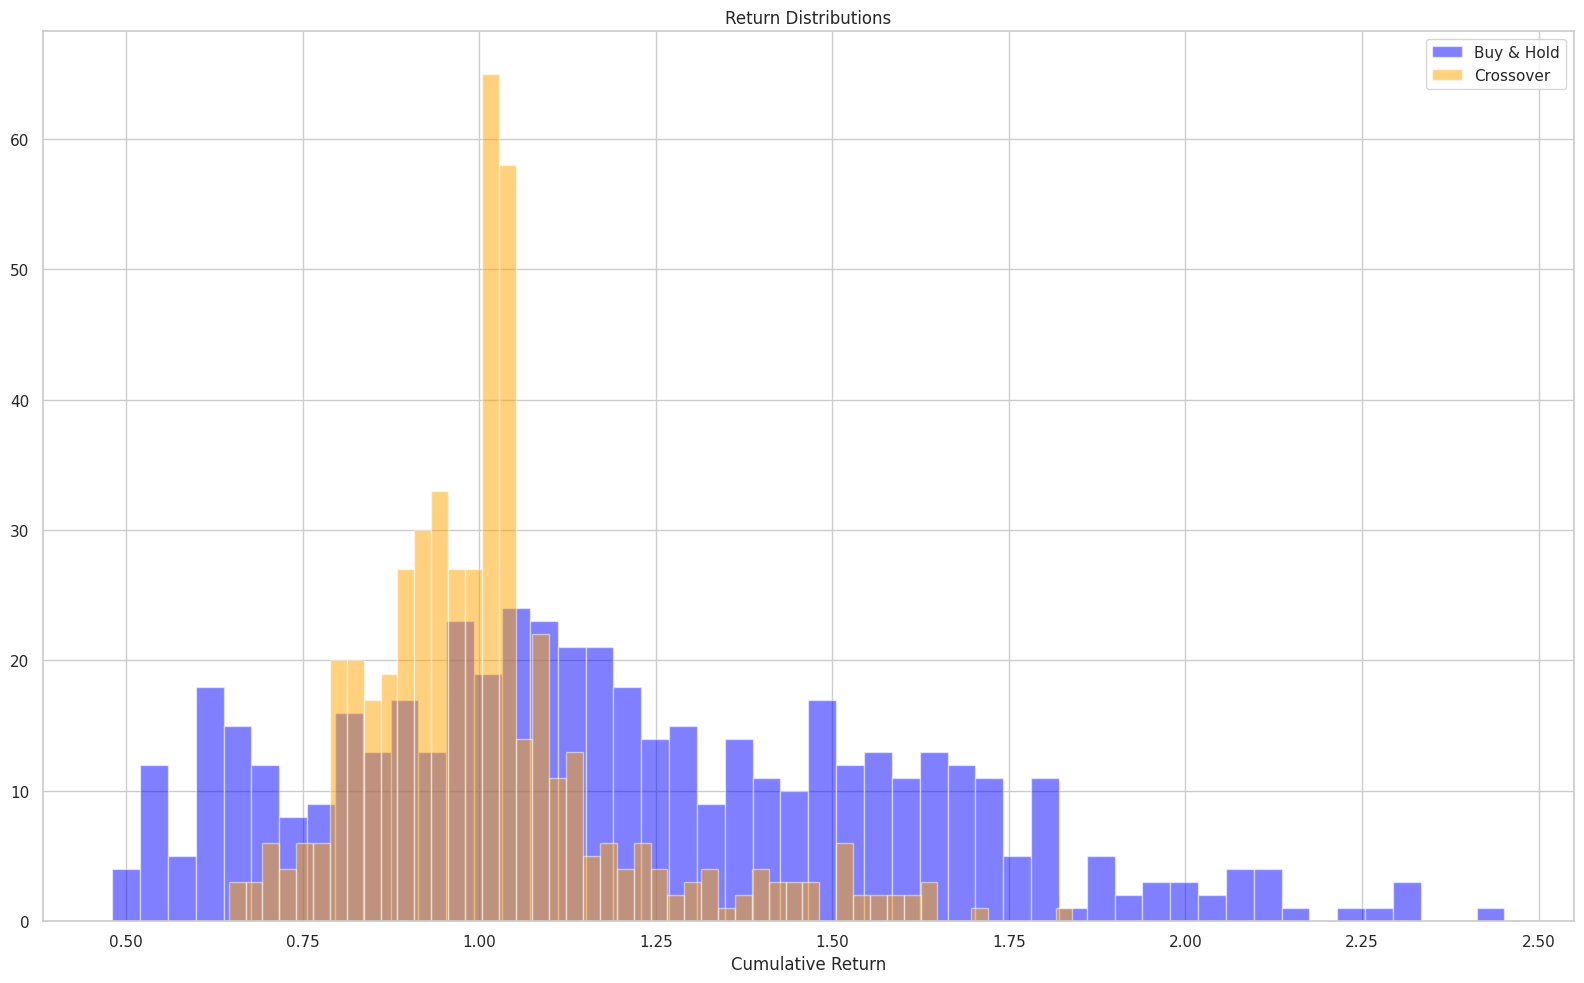

In [162]:
#plotting the distributions of returns for the ticker selected at the beginning
sns.set(style="whitegrid")
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1)  # 1 row, 1 column, 1st subplot
ax.hist(results_df['Final_Buy_Hold'], bins=50, alpha=0.5, label='Buy & Hold', color='blue')
ax.hist(results_df['Final_Strategy_with_Costs'], bins=50, alpha=0.5, label='Crossover', color='orange')
ax.set_title('Return Distributions')
ax.legend()
ax.set_xlabel('Cumulative Return')
plt.tight_layout()
plt.show()

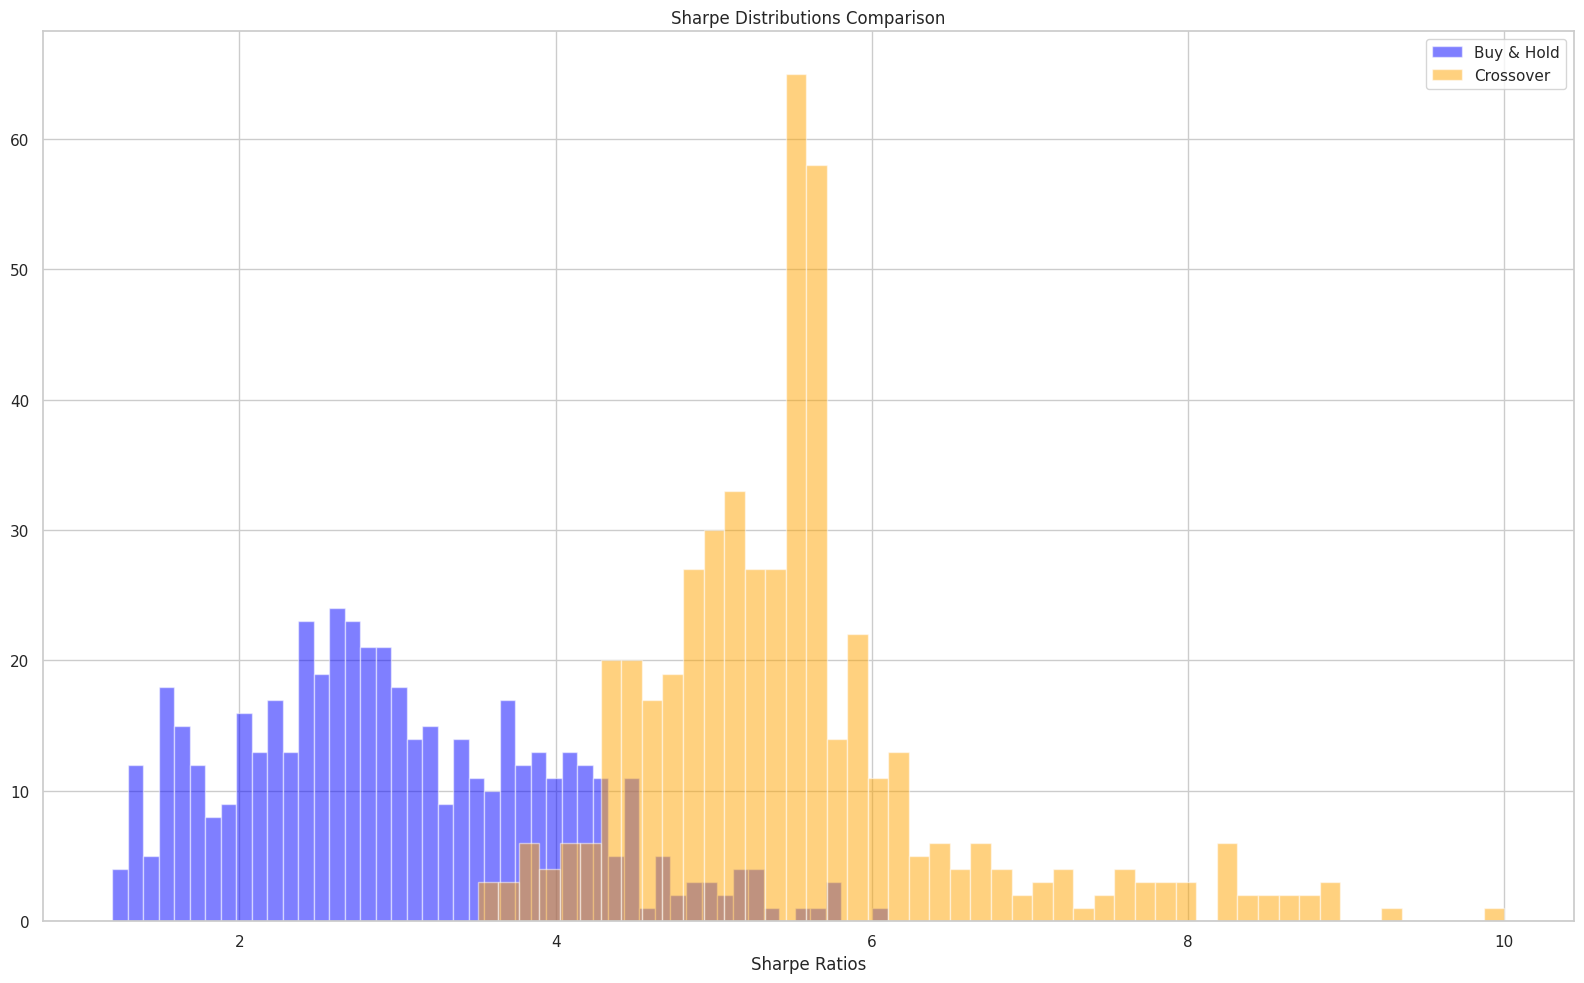

In [163]:
#plotting the distributions of the sharpe for the ticker selected at the beginning
sns.set(style="whitegrid")
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1)  # 1 row, 1 column, 1st subplot
ax.hist(results_df['sharpe_bh'], bins=50, alpha=0.5, label='Buy & Hold', color='blue')
ax.hist(results_df['sharpe_strat'], bins=50, alpha=0.5, label='Crossover', color='orange')
ax.set_title('Sharpe Distributions Comparison')
ax.legend()
ax.set_xlabel('Sharpe Ratios')
plt.tight_layout()
plt.show()

The real sharpe defined as the average return over the evolatility can be calculated as

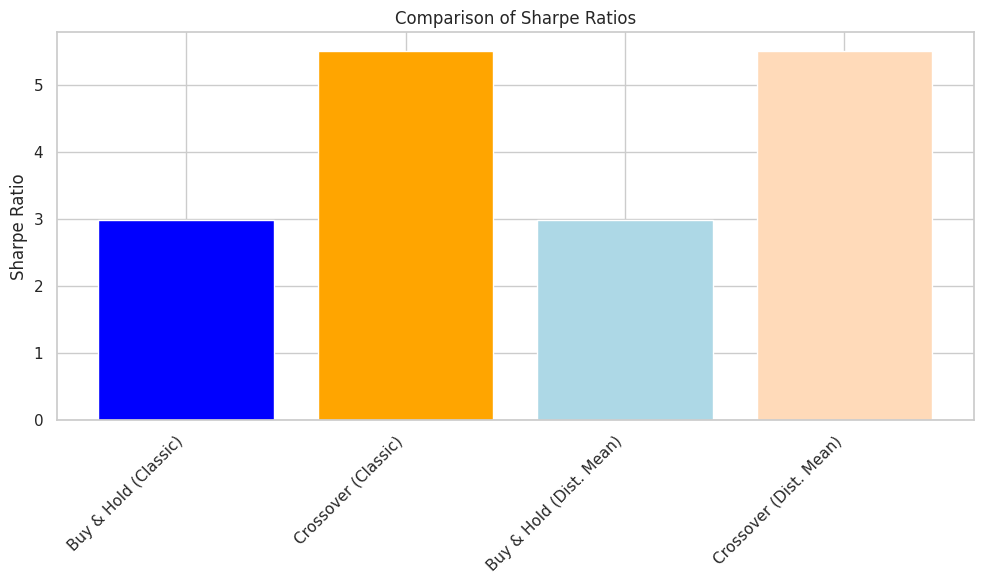

In [164]:
#sharpe ratios
sharpe_bh_classic = results_df['Final_Buy_Hold'].mean() / volatility_bh
sharpe_strat_classic = results_df['Final_Strategy_with_Costs'].mean() / volatility_strat
sharpe_bh_mean_sharpe_bh_distribution = results_df['sharpe_bh'].mean()
sharpe_strat_mean_sharpe_strat_distribution = results_df['sharpe_strat'].mean()

#bar chart
sharpe_ratios = [sharpe_bh_classic, sharpe_strat_classic,
                  sharpe_bh_mean_sharpe_bh_distribution, sharpe_strat_mean_sharpe_strat_distribution]
labels = ['Buy & Hold (Classic)', 'Crossover (Classic)',
           'Buy & Hold (Dist. Mean)', 'Crossover (Dist. Mean)']
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(labels))
ax.bar(x_pos, sharpe_ratios, color=['blue', 'orange', 'lightblue', 'peachpuff'])
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Comparison of Sharpe Ratios')
plt.tight_layout()
plt.show()